In [2]:
import pandas as pd

In [4]:
# Load the dataset
df = pd.read_csv('Electricity_forecasting_dataset.csv')

In [6]:
# Display first few rows
df.head()

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


In [8]:
# Check column names and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54170 entries, 0 to 54169
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   DateTime       54170 non-null  object
 1   Consumption    54170 non-null  int64 
 2   Production     54170 non-null  int64 
 3   Nuclear        54170 non-null  int64 
 4   Wind           54170 non-null  int64 
 5   Hydroelectric  54170 non-null  int64 
 6   Oil and Gas    54170 non-null  int64 
 7   Coal           54170 non-null  int64 
 8   Solar          54170 non-null  int64 
 9   Biomass        54170 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 4.1+ MB


In [10]:
# Rename column if needed
df.columns = df.columns.str.strip()

In [12]:
# Convert DateTime
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [14]:
# Set datetime as index
df.set_index('DateTime', inplace=True)

In [16]:
# Final check
df.head()

,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
DateTime,,,,,,,,,
2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30


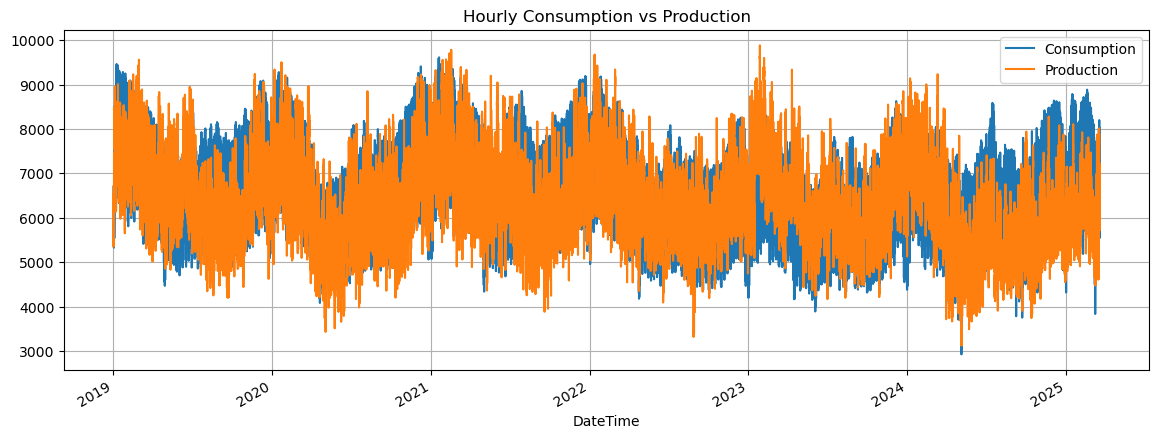

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Time features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

# Line plot: Consumption & Production over time
plt.figure(figsize=(14,5))
df[['Consumption', 'Production']].plot(ax=plt.gca())
plt.title('Hourly Consumption vs Production')
plt.grid(True)
plt.show()

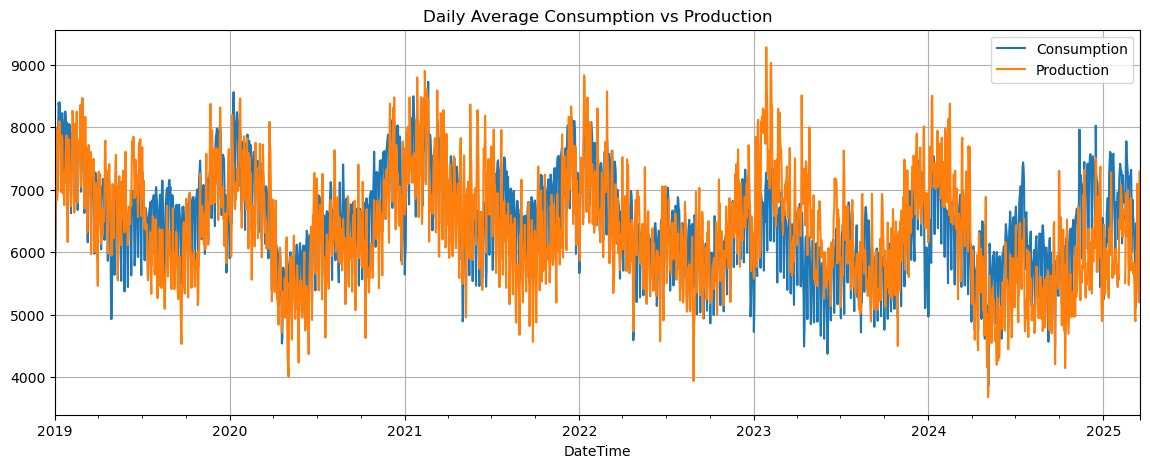

In [32]:
df_resampled = df.resample('D').mean()
df_resampled[['Consumption', 'Production']].plot(figsize=(14,5))
plt.title('Daily Average Consumption vs Production')
plt.grid(True)
plt.show()


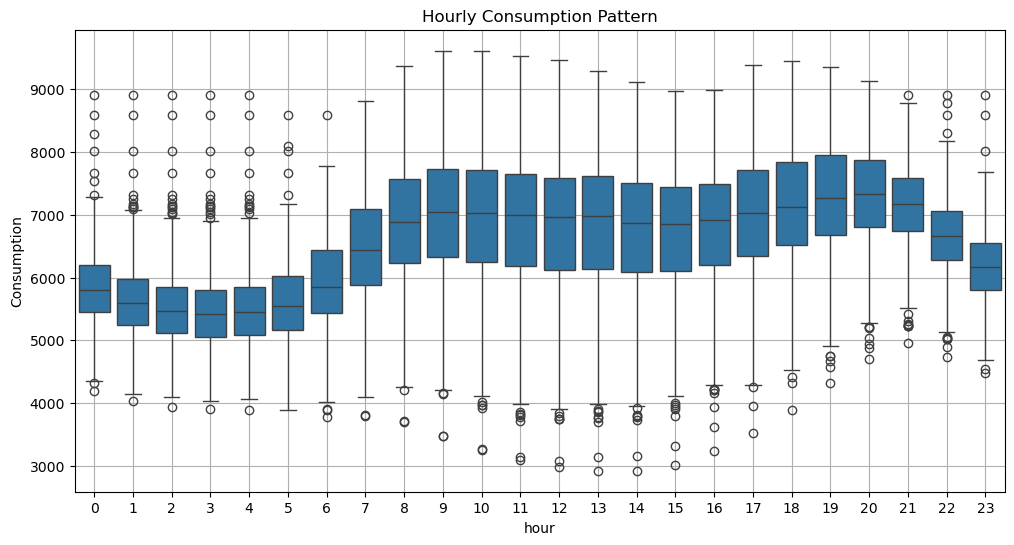

In [20]:
# Boxplot by hour
plt.figure(figsize=(12,6))
sns.boxplot(x='hour', y='Consumption', data=df)
plt.title('Hourly Consumption Pattern')
plt.grid(True)
plt.show()

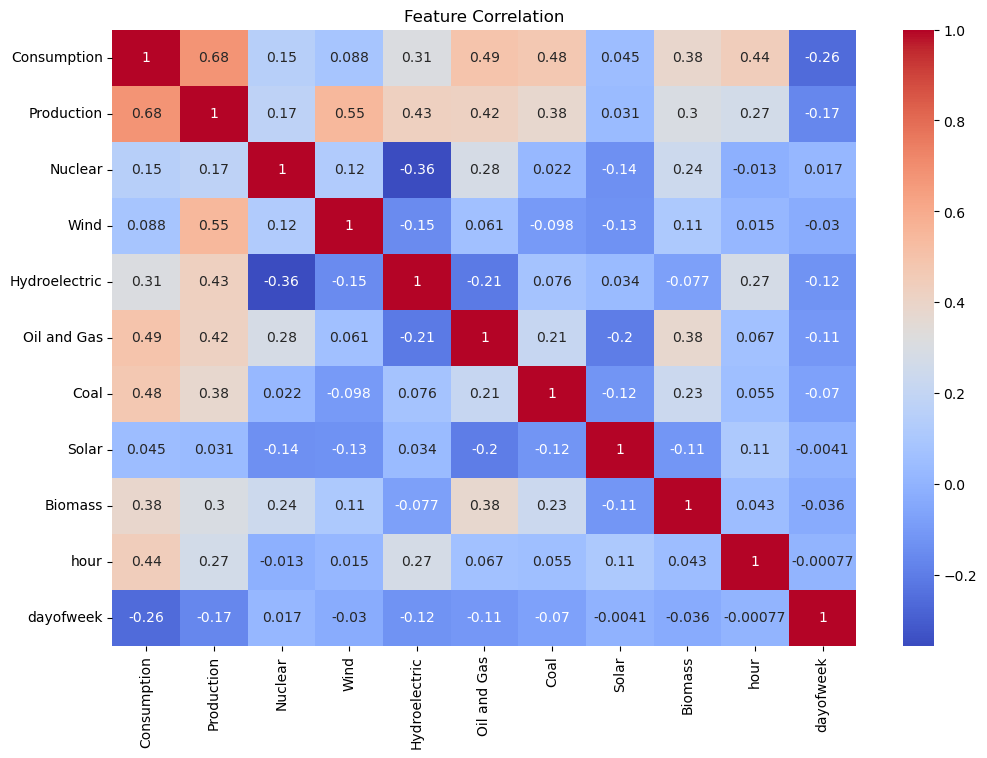

In [22]:
# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()


In [36]:
import numpy as np

SEQ_LEN = 24  # last 24 hours
FUTURE_STEPS = 6  # next 6 hours

features = ['Consumption', 'Production', 'Nuclear', 'Wind', 'Hydroelectric', 
            'Oil and Gas', 'Coal', 'Solar', 'Biomass', 'hour', 'dayofweek']

# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features, index=df.index)

# Sequence generation
def create_multistep_sequences(data, input_seq, output_seq):
    X, y = [], []
    for i in range(len(data) - input_seq - output_seq):
        X.append(data[i:i+input_seq])
        y.append(data[i+input_seq:i+input_seq+output_seq, 0])  # Only target (Consumption)
    return np.array(X), np.array(y)

X, y = create_multistep_sequences(scaled_df.values, SEQ_LEN, FUTURE_STEPS)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)


In [38]:
from sklearn.model_selection import train_test_split

# Train-test split (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [44]:
# Step 2: Feature Engineering
df_feat = df.copy()

# -------------------------
# 📆 Time-based features
# -------------------------
df_feat['hour'] = df_feat.index.hour
df_feat['dayofweek'] = df_feat.index.dayofweek
df_feat['is_weekend'] = df_feat['dayofweek'].isin([5, 6]).astype(int)
df_feat['month'] = df_feat.index.month

# ----------------------------------------
# 🔁 Lag features (1, 2, 3 hours ago)
# ----------------------------------------
for lag in [1, 2, 3]:
    df_feat[f'lag_{lag}'] = df_feat['Consumption'].shift(lag)

# ----------------------------------------------------
# 📊 Rolling mean & std (6, 12, 24 hours window)
# ----------------------------------------------------
for window in [6, 12, 24]:
    df_feat[f'roll_mean_{window}'] = df_feat['Consumption'].rolling(window).mean()
    df_feat[f'roll_std_{window}'] = df_feat['Consumption'].rolling(window).std()

# Drop NA values caused by lag/rolling
df_feat = df_feat.dropna()

# View sample
df_feat.head()


,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass,hour,...,lag_3,rolling_mean_3,is_weekend,month,roll_mean_6,roll_std_6,roll_mean_12,roll_std_12,roll_mean_24,roll_std_24
DateTime,,,,,,,,,,,,,,,,,,,,,
2019-01-02 02:00:00,5385,6009,1392,1613,676,1036,1257,0,35,2,...,5936.0,5510.666667,0,1,5855.166667,418.290529,6136.416667,488.317046,5882.291667,431.566356
2019-01-02 03:00:00,5327,6062,1390,1823,534,1034,1246,0,35,3,...,5647.0,5404.000000,0,1,5669.500000,347.494317,6095.916667,535.457571,5867.500000,444.616102
2019-01-02 04:00:00,5362,5867,1390,1739,418,1021,1264,0,35,4,...,5500.0,5358.000000,0,1,5526.166667,232.290694,6042.000000,576.041192,5859.375000,452.253085
2019-01-02 05:00:00,5411,5878,1389,1592,499,1098,1265,0,35,5,...,5385.0,5366.666667,0,1,5438.666667,117.607256,5941.833333,572.218781,5854.625000,456.496470
2019-01-02 06:00:00,5510,5996,1388,1478,565,1258,1271,0,35,6,...,5327.0,5427.666667,0,1,5415.833333,74.451103,5841.166667,527.792803,5854.500000,456.594483


In [46]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select features
features = df_feat.columns.tolist()
features.remove("Consumption")  # Target separate

# Normalize features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df_feat[features])

# Normalize target
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(df_feat[['Consumption']])

# Set sequence and forecast length
SEQ_LENGTH = 24  # past 24 hours
FORECAST_HORIZON = 6  # predict next 6 hours

# Create sequences for multi-step forecasting
def create_multistep_sequences(X, y, seq_len, forecast_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len - forecast_len + 1):
        Xs.append(X[i: i + seq_len])
        ys.append(y[i + seq_len: i + seq_len + forecast_len].flatten())
    return np.array(Xs), np.array(ys)

# Build sequences
X, y = create_multistep_sequences(X_scaled, y_scaled, SEQ_LENGTH, FORECAST_HORIZON)

# Shape check
print("Input shape:", X.shape)
print("Target shape:", y.shape)


Input shape: (54115, 24, 22)
Target shape: (54115, 6)


In [48]:
from sklearn.model_selection import train_test_split

# Train-test split (no shuffle)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [141]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout

model = Sequential([
    Input(shape=(SEQ_LENGTH, X.shape[2])),     # <-- NEW Input layer
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(FORECAST_HORIZON)
])


In [140]:
model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)


In [138]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.0216 - val_loss: 0.0027 - learning_rate: 0.0010
Epoch 2/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0039 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 3/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0026 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0019 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0016 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 6/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0014 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0013 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 8/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0012 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 9/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0011 - val_loss: 0.001

In [102]:
model.save('lstm_model.keras')



339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


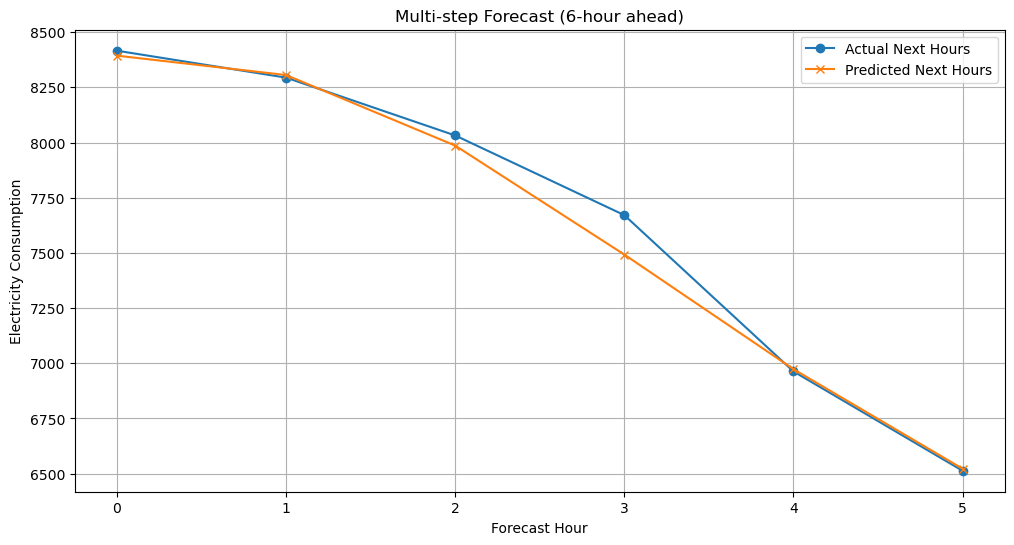

In [58]:
# Predict
predictions = model.predict(X_test)

# Inverse scale
y_test_inv = scaler_y.inverse_transform(y_test)
predictions_inv = scaler_y.inverse_transform(predictions)

# Plot the first prediction vs actual
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_inv[0], label='Actual Next Hours', marker='o')
plt.plot(predictions_inv[0], label='Predicted Next Hours', marker='x')
plt.title('Multi-step Forecast (6-hour ahead)')
plt.xlabel('Forecast Hour')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.grid(True)
plt.show()


In [60]:
!pip install tensorflow scikit-learn matplotlib pandas


In [62]:
from tensorflow.keras.layers import Input, LayerNormalization, Dense, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-Head Attention
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = LayerNormalization(epsilon=1e-6)(x + inputs)

    # Feed Forward
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Dropout(dropout)(x_ff)
    x = LayerNormalization(epsilon=1e-6)(x + x_ff)
    return x


In [84]:
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model

# define the number of time steps to predict
FORECAST_HORIZON = y_train.shape[1]

def build_transformer_model(input_shape, head_size=64, num_heads=2, ff_dim=128, num_transformer_blocks=2, dropout=0.1):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = Flatten()(x)
    x = Dropout(dropout)(x)
    outputs = Dense(FORECAST_HORIZON)(x)  # Predict multiple steps ahead
    model = Model(inputs, outputs)
    model.compile(loss="mse", optimizer="adam")
    return model

# Rebuild model
transformer_model = build_transformer_model(input_shape=(SEQ_LEN, X_train.shape[2]))


In [86]:
transformer_history = transformer_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[
        EarlyStopping(patience=10, restore_best_weights=True),
        ReduceLROnPlateau(patience=5)
    ]
)

# Predict
transformer_preds = transformer_model.predict(X_test)

# Evaluation
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

print(f"Transformer R²: {r2_score(y_test, transformer_preds)}")
print(f"Transformer MAE: {mean_absolute_error(y_test, transformer_preds)}")
print(f"Transformer RMSE: {np.sqrt(mean_squared_error(y_test, transformer_preds))}")


Epoch 1/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.1426 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 2/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0067 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 3/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0034 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 4/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0023 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 5/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0018 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 6/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 7/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0013 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 8/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 0.0012 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 9/30
1083/1083 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0012 - val_loss: 0.001

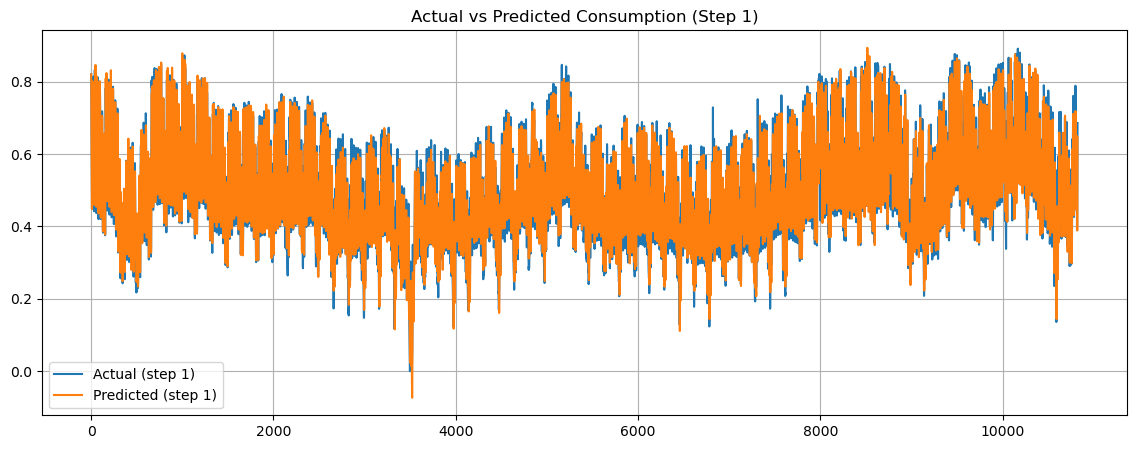

In [88]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_test[:, 0], label='Actual (step 1)')
plt.plot(transformer_preds[:, 0], label='Predicted (step 1)')
plt.title('Actual vs Predicted Consumption (Step 1)')
plt.legend()
plt.grid(True)
plt.show()


In [104]:
transformer_model.save('transformer_model.keras')


In [116]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import tensorflow as tf

# Load saved models
lstm_model = tf.keras.models.load_model('lstm_model.keras', compile=False)
transformer_model = tf.keras.models.load_model('transformer_model.keras', compile=False)

import numpy as np
import os

# Assuming you already have X_test and y_test variables in memory

os.makedirs('data', exist_ok=True)  # Create folder if not exists

np.save('data/X_test.npy', X_test)
np.save('data/y_test.npy', y_test)


# Load test data
X_test = np.load('data/X_test.npy')
y_test = np.load('data/y_test.npy')


# Predict using both models
lstm_preds = lstm_model.predict(X_test)
transformer_preds = transformer_model.predict(X_test)

# Ensure shapes are compatible (reshape if needed)
if lstm_preds.shape != y_test.shape:
    lstm_preds = lstm_preds.reshape(y_test.shape)
if transformer_preds.shape != y_test.shape:
    transformer_preds = transformer_preds.reshape(y_test.shape)

# LSTM metrics
print("📈 LSTM Model Performance:")
print(f"R²: {r2_score(y_test, lstm_preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, lstm_preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, lstm_preds)):.4f}")

# Transformer metrics
print("\n🤖 Transformer Model Performance:")
print(f"R²: {r2_score(y_test, transformer_preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, transformer_preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, transformer_preds)):.4f}")


339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
339/339 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
📈 LSTM Model Performance:
R²: 0.8539
MAE: 0.0405
RMSE: 0.0576

🤖 Transformer Model Performance:
R²: 0.8658
MAE: 0.0380
RMSE: 0.0552


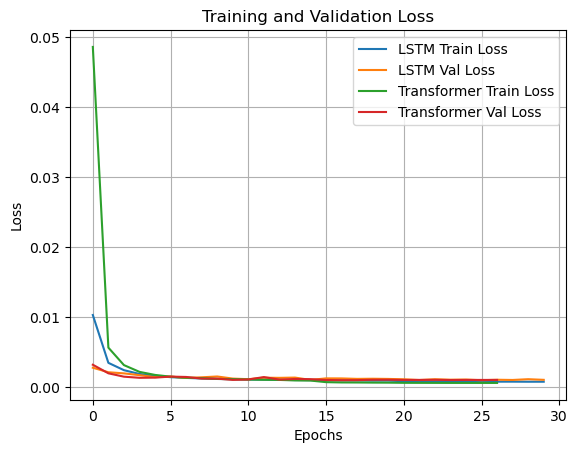

In [145]:
plt.plot(history.history['loss'], label='LSTM Train Loss')
plt.plot(history.history['val_loss'], label='LSTM Val Loss')
plt.plot(transformer_history.history['loss'], label='Transformer Train Loss')
plt.plot(transformer_history.history['val_loss'], label='Transformer Val Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
